
# 🧩 Two-Node RAG with LangGraph (Story Writer over Character Sheets)

This notebook builds a **minimal but solid** Retrieval-Augmented Generation (RAG) system in **two nodes** using **LangGraph** and **OpenAI**:
1. `retrieve_character_facts` — retrieve character & world facts for the requested story
2. `write_story_with_evidence` — write a short story **grounded** in retrieved facts, with inline evidence markers

> External corpus: character sheets (personality, likes, taboos, etc.) + shared world notes.
>
> You can run this locally after filling your OpenAI key. The notebook includes optional `pip install` cells.



## 0. Setup
- Fill your OpenAI API key in `.env` or environment.
- (Optional) Install dependencies if you don't have them.


In [1]:

# If needed, uncomment to install locally:
# !pip install -U langgraph langchain pydantic python-dotenv
# NOTE: You can also use FAISS/Chroma, but here we do a tiny in-memory index for clarity.


In [2]:

from dotenv import load_dotenv
from openai import OpenAI
import os, json, math, numpy as np
from dataclasses import dataclass, asdict
from typing import List, Dict, Any, Optional, TypedDict

load_dotenv()
client = OpenAI()

_USE_OPENAI = True  # flip to False if you want to stub responses for offline tests
EMBED_MODEL = os.getenv("EMBED_MODEL", "text-embedding-3-small")
CHAT_MODEL  = os.getenv("CHAT_MODEL", "gpt-5-mini")
SEED = 7
np.random.seed(SEED)

print("Using chat model:", CHAT_MODEL)
print("Using embed model:", EMBED_MODEL)


Using chat model: gpt-5-mini
Using embed model: text-embedding-3-small



## 1. Create a tiny corpus (character sheets + shared world)
We keep documents small and structured; we will store them with metadata and embed their *content*.


In [3]:

@dataclass
class Doc:
    doc_id: str
    content: str
    metadata: Dict[str, Any]

corpus: List[Doc] = [
    Doc(
        doc_id="Alice.traits.md",
        content=(
            "name: Alice\n"
            "traits: 内向、强迫症、记日记\n"
            "likes_food: 抹茶、寿司\n"
            "dislikes_food: 榴莲\n"
            "hobbies: 观星、拼乐高\n"
            "speech: 轻声、短句、常用“嗯…好”\n"
            "background: 城市图书管理员\n"
            "taboos: 讨厌别人未经同意触碰她的笔记本\n"
        ),
        metadata={"type": "character", "name": "Alice", "updated_at": "2025-06-01"},
    ),
    Doc(
        doc_id="Bob.traits.md",
        content=(
            "name: Bob\n"
            "traits: 外向、冲动、讲冷笑话\n"
            "likes_food: 烤肉、黑咖啡\n"
            "hobbies: 跑酷、修自行车\n"
            "speech: 夸张比喻、句尾常说“懂？”\n"
            "background: 外卖骑手\n"
            "taboos: 被人质疑路线感\n"
        ),
        metadata={"type": "character", "name": "Bob", "updated_at": "2025-06-10"},
    ),
    Doc(
        doc_id="Setting.shared.md",
        content=(
            "city: 雨水充沛的港口城\n"
            "common_places: 旧书店、码头、陡坡石阶\n"
            "cultural_notes: 雨夜猫会聚到码头最旧的灯塔边\n"
        ),
        metadata={"type": "setting", "name": "SharedWorld", "updated_at": "2025-05-20"},
    ),
]
len(corpus), [d.doc_id for d in corpus]


(3, ['Alice.traits.md', 'Bob.traits.md', 'Setting.shared.md'])

In [25]:
corpus[0].content

'name: Alice\ntraits: 内向、强迫症、记日记\nlikes_food: 抹茶、寿司\ndislikes_food: 榴莲\nhobbies: 观星、拼乐高\nspeech: 轻声、短句、常用“嗯…好”\nbackground: 城市图书管理员\ntaboos: 讨厌别人未经同意触碰她的笔记本\n'


## 2. Build a minimal in-memory vector index
We embed each document with OpenAI Embeddings and store vectors in memory. Retrieval is cosine similarity.


In [4]:

def embed_texts(texts: List[str]) -> np.ndarray:
    if not _USE_OPENAI:
        # offline stub
        return np.random.normal(0, 1, (len(texts), 1536)).astype("float32")
    resp = client.embeddings.create(model=EMBED_MODEL, input=texts)
    vecs = [np.array(d.embedding, dtype="float32") for d in resp.data]
    return np.vstack(vecs)

doc_vectors = embed_texts([d.content for d in corpus])
doc_norms = np.linalg.norm(doc_vectors, axis=1, keepdims=True) + 1e-8
doc_vectors = doc_vectors / doc_norms  # normalize
print("Index built. Shape:", doc_vectors.shape)


Index built. Shape: (3, 1536)


In [5]:

def cosine_topk(query: str, k: int = 6, filters: Optional[Dict[str, Any]] = None) -> List[Doc]:
    # Apply simple metadata filter before scoring
    candidates = corpus
    if filters:
        def _ok(doc: Doc):
            for key, val in filters.items():
                if isinstance(val, dict) and "$in" in val:
                    if doc.metadata.get(key) not in val["$in"]:
                        return False
                else:
                    if doc.metadata.get(key) != val:
                        return False
            return True
        candidates = [d for d in corpus if _ok(d)]
    # Compute embedding for query
    qv = embed_texts([query])[0]
    qv = qv / (np.linalg.norm(qv) + 1e-8)
    # Score only candidate subset
    idxs = [corpus.index(d) for d in candidates]
    mat = doc_vectors[idxs]
    scores = (mat @ qv).tolist()
    ranked = sorted(zip(scores, candidates), key=lambda x: x[0], reverse=True)
    return [d for _, d in ranked[:k]]



## 3. LangGraph: define state and two nodes
We split RAG into **retrieve → generate**.


In [6]:

# If not installed, pip install in the first cell
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


In [7]:

class StoryRAGState(TypedDict):
    theme: str
    characters: List[str]
    style: str
    length: str
    retrieved_docs: List[Dict[str, Any]]
    outline: str
    story: str



### Node 1 — retrieve_character_facts
- Prioritize character docs whose `name` in requested characters
- Also include shared `setting` doc
- Merge & (optionally) rerank by the same query


In [8]:

def retrieve_character_facts(state: StoryRAGState) -> StoryRAGState:
    theme = state["theme"]
    characters = state["characters"]
    query = f"{theme} :: " + ", ".join(characters)

    # 1) character-focused filter
    char_docs = []
    if characters:
        char_docs = cosine_topk(query, k=6, filters={"type": "character", "name": {"$in": characters}})
    # 2) shared setting
    setting_docs = cosine_topk(query, k=3, filters={"type": "setting"})

    # 3) simple merge + distinct by doc_id
    merged = {}
    for d in char_docs + setting_docs:
        merged[d.doc_id] = d
    docs = list(merged.values())

    # 4) package into JSON-safe dicts
    out_docs = [{
        "doc_id": d.doc_id,
        "content": d.content,
        "metadata": d.metadata,
    } for d in docs]

    new_state = dict(state)
    new_state["retrieved_docs"] = out_docs
    return new_state



### Node 2 — write_story_with_evidence
We convert retrieved docs into a compact bullet summary and instruct the model to:
- produce a brief outline (conflict → development → resolution) that references facts,
- then write a short story using **inline evidence markers** like `【Alice: likes 抹茶】`.


In [9]:

def summarize_docs_for_prompt(docs: List[Dict[str, Any]]) -> str:
    bullets = []
    for d in docs:
        meta = d.get("metadata", {})
        src = d.get("doc_id")
        name = meta.get("name", meta.get("type", "doc"))
        bullets.append(f"- [{src}] name={name}, type={meta.get('type')}, updated_at={meta.get('updated_at')}")
        # show only first ~6 key lines to keep prompt short
        lines = [ln.strip() for ln in d["content"].splitlines() if ln.strip()]
        for ln in lines[:6]:
            bullets.append(f"  · {ln}")
    return "\n".join(bullets)

SYSTEM_PROMPT = (
    "你是一个严格遵循证据的人设一致性写作助手。"
    "基于提供的人物与世界设定来写短篇。如果某项设定缺失，允许合理推断，但用括号标注‘推断’。"
    "在正文中，当你使用到关键设定时，用行内标注如【Alice: likes 抹茶】。"
    "禁止与证据冲突；保持角色口吻与禁忌一致。"
)

def write_story_with_evidence(state: StoryRAGState) -> StoryRAGState:
    theme = state["theme"]
    characters = state["characters"]
    style = state.get("style", "叙事自然、细腻治愈，略带幽默")
    length = state.get("length", "short")

    docs = state.get("retrieved_docs", [])
    evidence = summarize_docs_for_prompt(docs)

    user_prompt = f'''
任务：根据人物设定与共享世界，写一个短篇故事。
主题：{theme}
角色：{", ".join(characters)}
风格：{style}
长度：{length}

证据（请严格遵循；缺失可(推断)）：
{evidence}

输出要求：
1) 先给三段式提纲（开端/推进/收束），提纲里明确点出会用到的设定（用✅标注）。
2) 再写正文；每当使用到关键设定时，加上行内证据标注，如【Alice: likes 抹茶】。
3) 若某项为推断，请在该处标注(推断)。
    '''.strip()

    if not _USE_OPENAI:
        outline = "开端/推进/收束（stub）"
        story = "这是一个离线 stub 故事。"
    else:
        messages = [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ]
        resp = client.chat.completions.create(
            model=CHAT_MODEL,
            messages=messages,
            temperature=1,
        )
        story_text = resp.choices[0].message.content
        # Small heuristic: split outline and story if user wants it split
        # Here we keep whole text but also set outline crudely as first block if detectable.
        outline = ""
        story  = story_text
        # naive split
        parts = story_text.split("\n\n", 1)
        if len(parts) == 2 and ("开端" in parts[0] or "提纲" in parts[0]):
            outline, story = parts[0], parts[1]

    new_state = dict(state)
    new_state["outline"] = outline
    new_state["story"] = story
    return new_state



## 4. Build the LangGraph
Start → retrieve_character_facts → write_story_with_evidence → End


In [10]:

graph = StateGraph(StoryRAGState)
graph.add_node("retrieve_character_facts", retrieve_character_facts)
graph.add_node("write_story_with_evidence", write_story_with_evidence)
graph.add_edge(START, "retrieve_character_facts")
graph.add_edge("retrieve_character_facts", "write_story_with_evidence")
graph.add_edge("write_story_with_evidence", END)
app = graph.compile()
print("Graph compiled.")


Graph compiled.


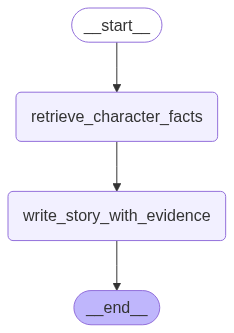

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Mermaid 生成失败（可忽略）：", e)


## 5. Try it
Change `theme`, `characters`, `style`, `length` and run.


In [11]:

initial_state: StoryRAGState = {
    "theme": "雨夜寻猫与错位的勇气",
    "characters": ["Alice", "Bob"],
    "style": "治愈系，细腻叙事，一点点幽默",
    "length": "short",
    "retrieved_docs": [],
    "outline": "",
    "story": "",
}
final_state = app.invoke(initial_state)
print("==== 提纲 ====")
print(final_state.get("outline",""))
print("\n==== 正文 ====")
print(final_state.get("story",""))


==== 提纲 ====
提纲
1) 开端：夜雨中，爱丽丝发现猫不见，翻看日记后决定去码头找猫。会用到的设定：✅Alice: traits（内向、强迫症、记日记）✅Alice: likes_food（抹茶）✅SharedWorld: cultural_notes（雨夜猫会聚到码头最旧的灯塔边）✅SharedWorld: city（雨水充沛的港口城）
2) 推进：在陡坡石阶上遇见鲍勃——外卖骑手，爱跑酷，会讲冷笑话，帮忙一起找猫。会用到的设定：✅Bob: background（外卖骑手）✅Bob: traits（外向、冲动、讲冷笑话）✅Bob: hobbies（跑酷、修自行车）✅SharedWorld: common_places（陡坡石阶、码头）
3) 收束：在旧灯塔旁找到猫，错位的勇气显现：爱丽丝轻声呼唤，鲍勃笨拙却真诚的鼓励，两人交换食物与温暖。会用到的设定：✅Alice: speech（轻声、常用“嗯…好”）✅Bob: speech（夸张比喻、句尾常说“懂？”）✅Alice/Bob: likes_food（抹茶、黑咖啡、烤肉）✅SharedWorld: cultural_notes（灯塔猫聚集）

==== 正文 ====
短篇故事
雨一直下着，像针线把港口城的夜缝成小格子【SharedWorld: city: 雨水充沛的港口城】。爱丽丝在灯下翻日记，笔迹被雨的节奏压得整齐，这是她的习惯——记下来，按列对齐，安心一点【Alice: traits: 内向、强迫症、记日记】。她确定门锁在原位，碗筷也按顺序放好，最后才发现猫不在窗台上。心口像被小石子敲了两下，决定出去找它。她把随身的小杯里剩下的抹茶抿了一口，温度在掌心里镇定了她一点【Alice: likes_food: 抹茶】（推断：保温杯带在身边以备夜里暖手）（推断）。

雨的味道里有盐，码头是第一时间浮现在她脑海的地方——港口的老话里，雨夜猫会聚到最旧的灯塔边【SharedWorld: cultural_notes: 雨夜猫会聚到码头最旧的灯塔边】。她沿着陡坡石阶下去，石阶湿滑，她的脚步有节奏，像是在完成一项检查清单【SharedWorld: common_places: 陡坡石阶】。有人从上面跃下，落地的姿势有一点戏剧性：是鲍勃，黑色外套还挂着外卖箱的轮廓，他脸上挂着可笑的笑容，像是刚从喜剧片里走出来的跑腿男


## 6. Inspect retrieved docs (observability)
Helpful to confirm RAG actually used the facts.


In [12]:

from pprint import pprint
print("Retrieved docs:")
pprint(final_state["retrieved_docs"])


Retrieved docs:
[{'content': 'name: Bob\n'
             'traits: 外向、冲动、讲冷笑话\n'
             'likes_food: 烤肉、黑咖啡\n'
             'hobbies: 跑酷、修自行车\n'
             'speech: 夸张比喻、句尾常说“懂？”\n'
             'background: 外卖骑手\n'
             'taboos: 被人质疑路线感\n',
  'doc_id': 'Bob.traits.md',
  'metadata': {'name': 'Bob', 'type': 'character', 'updated_at': '2025-06-10'}},
 {'content': 'name: Alice\n'
             'traits: 内向、强迫症、记日记\n'
             'likes_food: 抹茶、寿司\n'
             'dislikes_food: 榴莲\n'
             'hobbies: 观星、拼乐高\n'
             'speech: 轻声、短句、常用“嗯…好”\n'
             'background: 城市图书管理员\n'
             'taboos: 讨厌别人未经同意触碰她的笔记本\n',
  'doc_id': 'Alice.traits.md',
  'metadata': {'name': 'Alice',
               'type': 'character',
               'updated_at': '2025-06-01'}},
 {'content': 'city: 雨水充沛的港口城\n'
             'common_places: 旧书店、码头、陡坡石阶\n'
             'cultural_notes: 雨夜猫会聚到码头最旧的灯塔边\n',
  'doc_id': 'Setting.shared.md',
  'metadata': {'name': 'SharedWorld',
        


## 7. Quick experiments
- Remove Bob's `likes_food` from corpus and re-run to see `(推断)` behavior.
- Add a conflicting old Bob note and a recent update (use `updated_at` in metadata) and change retriever logic to prefer recency.
- Change the theme to involve the lighthouse; ensure the setting doc gets retrieved.
- Try single-character stories.
